# Entendendo o Problema CNLS com restrições reduzidas

Abaixo está o resultado da otimização com todas as restrições, entretanto podemos ver que grande parte delas é redundante pois ao final do problema temos apenas 4 planos gerados. o objetivo desse documento é encontrar uma forma de solucionar o problema escolhendo quanto menos restrições possíveis para solucionar o mesmo problema encontrando o mesmo resultado ótimo.
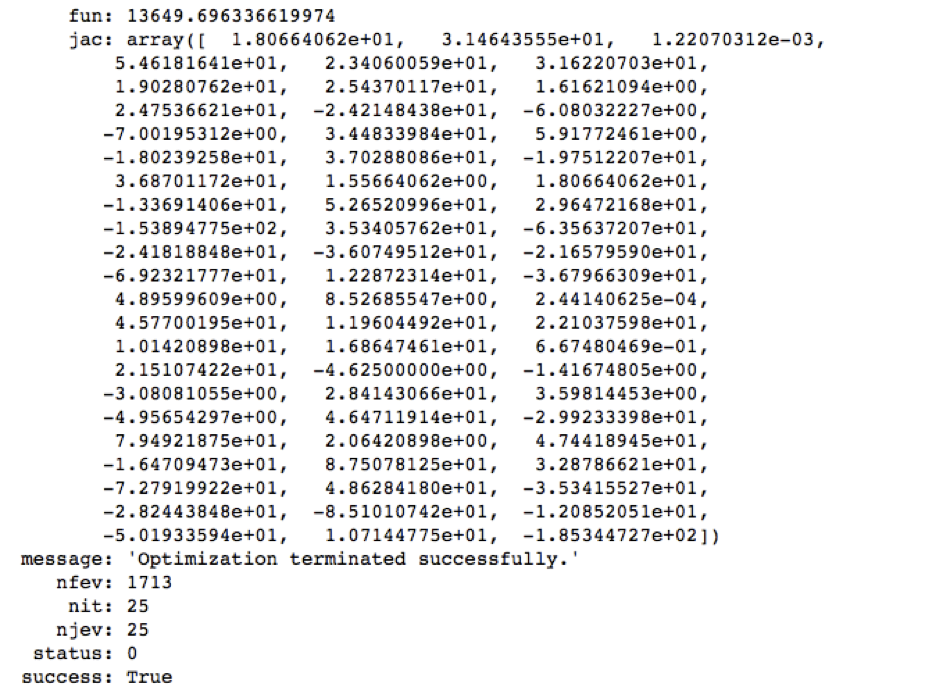
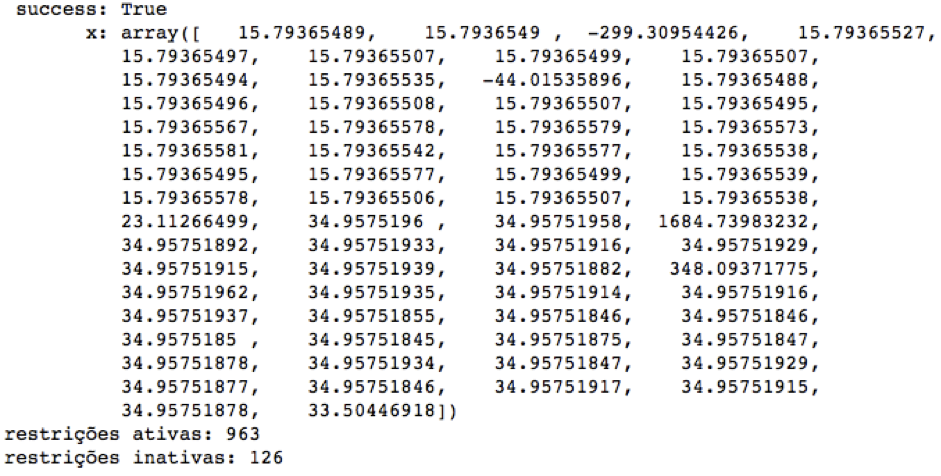
### Boa Sorte!

# All Initializing Preceadures

In [1]:
import numpy as np
from scipy.optimize import minimize

data_outputs =  np.array([[262521.02907266,346760.656260418,461290.60448595,344188.863677228,294231.297066693,345783.525320436,670122.214940625,786296.233232622,727266.439858377,687145.593548194,613688.786934742,177792.367994311,411511.034331357,475665.819349655,2102727.8261244,337951.80373594,249122.662771625,985591.107898336,462249.512119451,1162960.84406201,219543.804449336,269794.86660802,655462.207361263,397384.070821253,106815.706326885,1092761.76551572,95351.9114732475,401326.485602659,244175.697125257,340890.953115421,162342.780828482,757537.710512358,273569.38914776]])/10000
data_outputs = np.transpose(data_outputs)
data_inputs =np.array([[66340.66664431],[43983.62],[55783.9667751247],[27521.3753251431],[41283],[19147.96],[55620.26491],[151465.12],[215567.507554621],[116756.978720517],[132607.15],[83766.1023802807],[125549.065648061],[166179.32],[503695.91],[86860.16263],[53314.9],[262555.258252406],[137649.034],[235881.91],[51067],[23269.3],[123209.322],[110915.32575],[18410],[47335.086682134],[27061.378],[87213.8],[69882.77],[60840.5736579949],[27137.42],[72536.3],[82441.55]])/100000
print('Inputs: ',data_inputs.shape)
print('Outputs: ',data_outputs.shape)
inputs = np.copy(data_inputs)
outputs = np.copy(data_outputs)
#flatting data
inputs = inputs.flatten('F')
outputs = outputs.flatten()

step_out = 0.0
step_inp = 0.0
for i in range(0,outputs.shape[0]):
    for j in range(0,outputs.shape[0]):
        if i<j:
            if outputs[i]>outputs[j]:
                step_out = outputs[j]
                outputs[j]=outputs[i]
                outputs[i] = step_out
                
                step_inp = inputs[j]
                inputs[j]=inputs[i]
                inputs[i] = step_inp
                
                i = 0
            else: i+=1
#horizontal stacking
data = np.around(np.hstack((outputs,inputs)),decimals=3)
print('data shape:',data.shape)

alpha = np.copy(outputs)
#alpha = np.array([[2.625,0.229,0.229,0.229]])
beta = np.copy(inputs)
#beta = np.array([[0],[3.611],[3.611],[3.611]])
#flatting data
alpha = alpha.flatten()
beta = beta.flatten()
#horizontal stacking
parameters = np.around(np.hstack((alpha,beta)),decimals=3)
print('parameters shape:',parameters.shape)

def function_to_minimize(p):
    function = 0.0
    h = outputs.shape[0]
    i = 0
    while i < outputs.shape[0]:
        function += (p[i] - data[i] + data[i + h]*p[i + h])**2
        i += 1
    return function
#print(function_to_minimize(parameters))

def constraints(i,j,c = outputs.shape[0]):
    cons=''
    str1='{\'type\': \'ineq\', \'fun\': lambda p: -(p['+str(i)+    '] + p['+str(i+c)+']*data['+str(c+i)+'])' 
    str2=                                     '+( p['+str(j)+'] + p['+str(j+c)+']*data['+str(c+i)+'])}'
    cons =cons+str1+str2+',\n'
    return cons

bounds = '('
for i in range(outputs.shape[0]):
    bounds += '(None,None),'
bounds+='\n'
for i in range(inputs.shape[0]):
    bounds += '(0,None),'
bounds += ')'
bounds = eval(bounds)

def checking_constraints(vetor):
    violadas = np.empty((1,2))
    i = 0 
    while i < c:
        j = 0
        while j < c:
            if round(vetor[i] + vetor[i+c]*data[c+i],5) > round( vetor[j] + vetor[j+c]*data[c+i],5):
                violadas = np.vstack((violadas,np.array([i,j])))
            j +=1
        i += 1
    violadas = np.delete(violadas,0,0)

    folgas = np.empty((1,2))
    i = 0 
    while i < c:
        j = 0
        while j < c:
            if round(vetor[i] + vetor[i+c]*data[c+i],5) < round( vetor[j] + vetor[j+c]*data[c+i],5):
                folgas = np.vstack((folgas,np.array([i,j])))
            j +=1
        i += 1
    folgas = np.delete(folgas,0,0)

    ativas = np.empty((1,2))
    i = 0
    while i < c:
        j = 0
        while j < c:
            if round(vetor[i] + vetor[i+c]*data[c+i],5) == round( vetor[j] + vetor[j+c]*data[c+i],5):
                ativas = np.vstack((ativas,np.array([i,j])))
            j +=1
        i += 1
    ativas = np.delete(ativas,0,0)
    
    return violadas,folgas,ativas

Inputs:  (33, 1)
Outputs:  (33, 1)
data shape: (66,)
parameters shape: (66,)


# Initial Constraints

In [2]:
cons='('
i = 0 
c = outputs.shape[0]
active = 0
while i < c:
    j = 0
    while j < c:
        if i != j:
            if i > j:
                cons+= constraints(i,j)
                active +=1
        j +=1
    i += 1
cons=cons[:-2]+')'
#print(cons)
cons = eval(cons)

print('activated constraints:',active)
print('deactivated constraints:',outputs.shape[0]*(outputs.shape[0] - 1) - active)

activated constraints: 528
deactivated constraints: 528


# Testando possíveis Rotinas

In [3]:
evaluation = minimize(function_to_minimize,parameters,method='SLSQP',bounds=bounds,constraints =cons)
vetor = evaluation['x']
violadas,folgas,ativas = checking_constraints(vetor)
alphas,betas = np.around(np.split(vetor,2),decimals=4)
#alphas = np.expand_dims(alphas,axis=0)
#betas = np.expand_dims(betas,axis=0)
resultado = evaluation['fun']

In [4]:
matrixAB = np.vstack((alphas,betas))
matrixAB = matrixAB.T
main_hyperplanes = np.unique(matrixAB,axis=0)
new_cons = np.array([])
for i in range(0,main_hyperplanes.shape[0]):
    count = 0
    for j in range(0,matrixAB.shape[0]):
        if np.equal(main_hyperplanes[i],matrixAB[j]).all() == True and count == 0:
            count = 1
            new_cons = np.hstack(([j],new_cons))
print(new_cons)

cons='('
i = 0 
c = outputs.shape[0]
active = 0
while i < c:
    j = 0
    while j < c:
        if i != j:
            if np.equal([i],new_cons).any() == True or i<j:
                cons+= constraints(i,j)
                active +=1
        j +=1
    i += 1
cons=cons[:-2]+')'
#print(cons)
cons = eval(cons)

print('activated constraints:',active)
print('deactivated constraints:',outputs.shape[0]*(outputs.shape[0] - 1) - active)

evaluation = minimize(function_to_minimize,parameters,method='SLSQP',bounds=bounds,constraints =cons)
vetor = evaluation['x']
violadas,folgas,ativas = checking_constraints(vetor)
alphas,betas = np.around(np.split(vetor,2),decimals=4)
#alphas = np.expand_dims(alphas,axis=0)
#betas = np.expand_dims(betas,axis=0)
resultado = evaluation['fun']
print(resultado)



[  0.  24.  26.  29.  30.  31.  10.  11.  15.  32.   2.]
activated constraints: 738
deactivated constraints: 318
13649.696243913015


In [5]:
matrixAB = np.vstack((alphas,betas))
matrixAB = matrixAB.T
main_hyperplanes = np.unique(matrixAB,axis=0)
print(main_hyperplanes)
print(evaluation['message'])

[[ -299.1698  1683.9832]
 [  -37.2085   312.4579]
 [   15.7943    34.9567]
 [   15.797     34.9561]]
Optimization terminated successfully.


[[ -222.2225583  1683.9832   ]
 [   39.7387417   312.4579   ]
 [   92.7415417    34.9567   ]
 [   92.7442417    34.9561   ]]


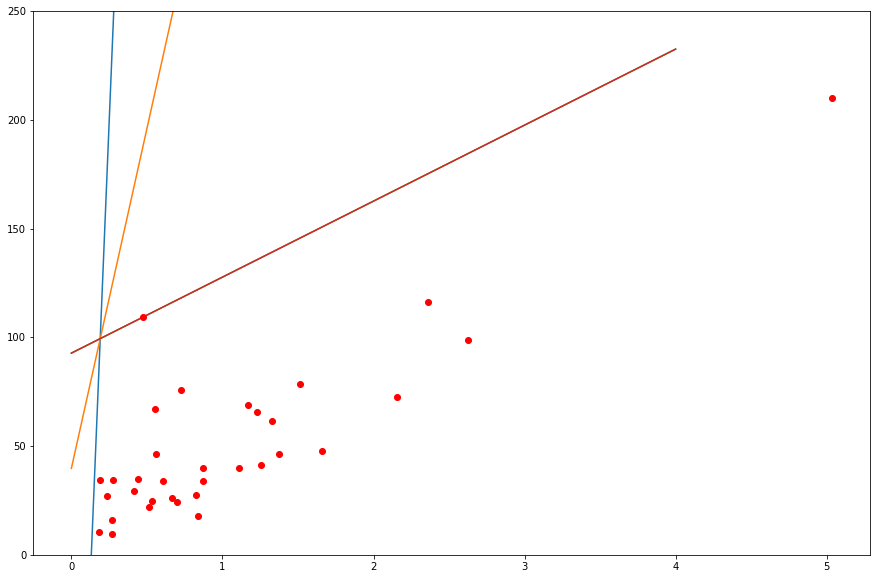

In [6]:
alphas,betas = np.around(np.split(vetor,2),decimals=4)
#alphas = np.expand_dims(alphas,axis=0)
#betas = np.expand_dims(betas,axis=0)

matrixAB = np.vstack((alphas,betas))
matrixAB = matrixAB.T
main_hyperplanes = np.unique(matrixAB,axis=0)

def highest_error(p):
    array = np.array([0])
    function = 0.0
    h = outputs.shape[0]
    i = 0
    while i < outputs.shape[0]:
        function = -p[i] + data[i] - data[i + h]*p[i + h]
        array = np.append(array,[function])
        i += 1
    return array

correct = np.amax(highest_error(vetor))

for i in range(0,main_hyperplanes.shape[0]):
    main_hyperplanes[i][0] += correct

print(main_hyperplanes)
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
for j in range(0,main_hyperplanes.shape[0]):
    x = [i for i in range(0,5)]
    y = [main_hyperplanes[j][0]+ main_hyperplanes[j][1]*i for i in x]
    plt.plot(x,y)

plt.plot(inputs,outputs,'ro')
plt.ylim(0,250)

plt.show()

# Routine

In [7]:
check = False
already_violated = np.array([[1.5,1.5]])

while check != True:
    
    #Optimizing
    evaluation = minimize(function_to_minimize,parameters,method='SLSQP',bounds=bounds,constraints =cons)
    vetor = evaluation['x']
     
    violadas,folgas,ativas = checking_constraints(vetor)
    
    for i in range(0,violadas.shape[0]):
        if any((violadas[i] != x).all() for x in already_violated):
            already_violated = np.vstack((already_violated,violadas[i]))
    cons='('
    i = 0 
    c = outputs.shape[0]
    compare = np.array([0,0])
    active = 0
    while i < c:
        j = 0
        while j < c:
            compare[0],compare[1] = i,j
            if i != j:
                if any((compare == x).all() for x in already_violated) == True or any((compare == x).all() for x in ativas):
                    cons+= constraints(i,j)
                    active +=1
            j +=1
        i += 1
    cons=cons[:-2]+')'
    cons = eval(cons)
    if str(violadas.shape[0]) == str(0):
        check = True
        already_violated = np.delete(already_violated,0,0)
        
print(evaluation)
print('restrições ativas:',ativas.shape[0])
print('restrições inativas:',folgas.shape[0])

     fun: 13649.696243913015
     jac: array([  1.80671387e+01,   3.14650879e+01,   2.19726562e-03,
         5.46179199e+01,   2.34062500e+01,   3.16220703e+01,
         1.90283203e+01,   2.54371338e+01,   1.61669922e+00,
         2.47532959e+01,  -2.42139893e+01,  -6.07958984e+00,
        -7.00158691e+00,   3.44831543e+01,   5.91784668e+00,
        -1.80233154e+01,   3.70278320e+01,  -1.97526855e+01,
         3.68676758e+01,   1.55566406e+00,   1.80629883e+01,
        -1.33701172e+01,   5.26505127e+01,   2.96464844e+01,
        -1.53894409e+02,   3.53392334e+01,  -6.35635986e+01,
        -2.41827393e+01,  -3.60778809e+01,  -2.16578369e+01,
        -6.92322998e+01,   1.22869873e+01,  -3.68039551e+01,
         4.89624023e+00,   8.52709961e+00,   4.88281250e-04,
         4.57698975e+01,   1.19606934e+01,   2.21037598e+01,
         1.01420898e+01,   1.68647461e+01,   6.67724609e-01,
         2.15106201e+01,  -4.62475586e+00,  -1.41650391e+00,
        -3.08056641e+00,   2.84140625e+01,   3

# Adjusting and Plotting

[[ -222.2225583  1683.9832   ]
 [   39.7387417   312.4579   ]
 [   92.7415417    34.9567   ]
 [   92.7442417    34.9561   ]]


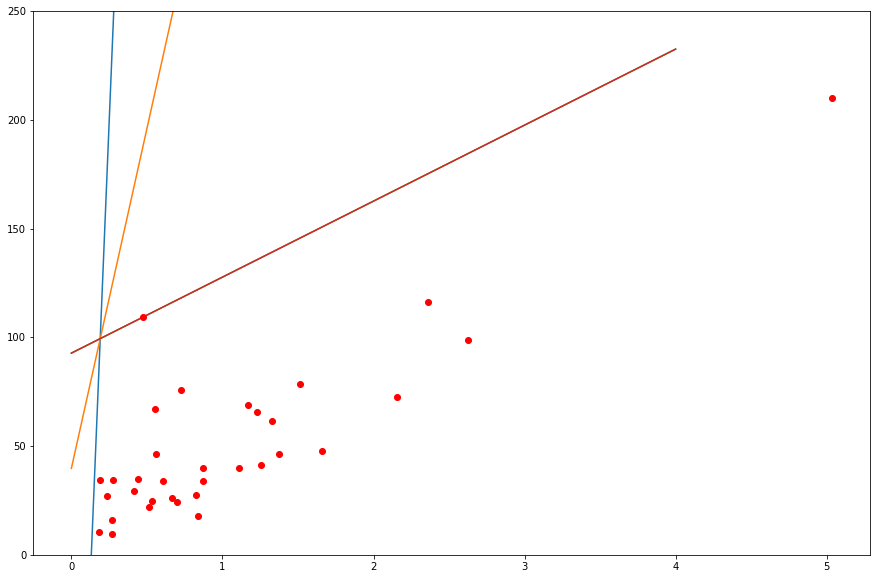

In [8]:
alphas,betas = np.around(np.split(vetor,2),decimals=4)
#alphas = np.expand_dims(alphas,axis=0)
#betas = np.expand_dims(betas,axis=0)

matrixAB = np.vstack((alphas,betas))
matrixAB = matrixAB.T
main_hyperplanes = np.unique(matrixAB,axis=0)

def highest_error(p):
    array = np.array([0])
    function = 0.0
    h = outputs.shape[0]
    i = 0
    while i < outputs.shape[0]:
        function = -p[i] + data[i] - data[i + h]*p[i + h]
        array = np.append(array,[function])
        i += 1
    return array

correct = np.amax(highest_error(vetor))

for i in range(0,main_hyperplanes.shape[0]):
    main_hyperplanes[i][0] += correct

print(main_hyperplanes)
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
for j in range(0,main_hyperplanes.shape[0]):
    x = [i for i in range(0,5)]
    y = [main_hyperplanes[j][0]+ main_hyperplanes[j][1]*i for i in x]
    plt.plot(x,y)

plt.plot(inputs,outputs,'ro')
plt.ylim(0,250)

plt.show()